## 0. U-Net 모델과 U-Net++ 모델 비교 

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.

모델의 구조는 아래 그림과 같습니다. U-Net++ 모델을 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었는지를 확인해 보겠습니다.   
정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보겠습니다.

- (참고) **[U-Net++ 저자 블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)**


![U_Net_.png](./images/U_Net_.png)

### Module import

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


import warnings
warnings.filterwarnings("ignore")

## 1. KITTI 데이터셋 수집과 구축
다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

### data augementation
Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 **Compose()**를 사용해서 data augementation을 진행하겠습니다. 

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),  # 최소 최대 사이즈
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

이미지를 가지고 와서 augementation을 적용해 보겠습니다.

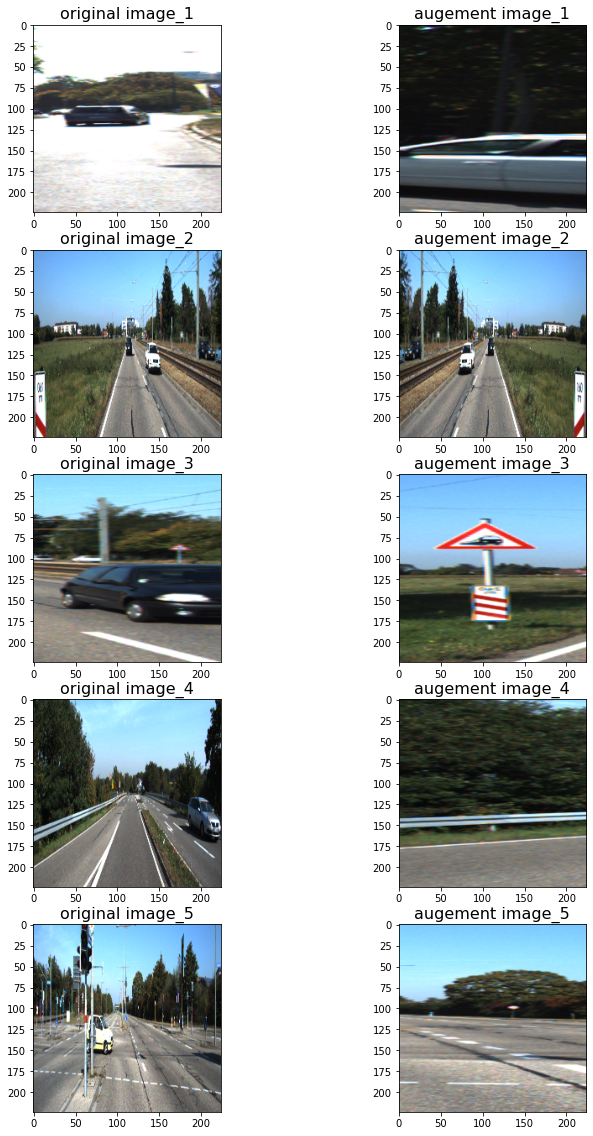

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

font_dict = {'fontsize' : 16}

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.title(f"original image_{i+1}",fontdict=font_dict)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.title(f"augement image_{i+1}",fontdict=font_dict)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

이미지 Augementation이 잘 적용된것을 확인할 수 있습니다.  
그러면 이제 데이터셋을 구성해 봅시다.  **tf.keras.utils.Sequence**를 상속받는 KittiGenrator 함수를 생성한 후 데이터를 구성해 보겠습니다.

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                dir_path,
                batch_size = 4,
                img_size=(224,224,3),
                output_size=(224,224),
                is_train=True,
                augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인한다.

        self.data = self.load_dataset()
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.    
        input_images = glob(os.path.join(self.dir_path, "image_2","*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic","*.png"))
        # input, label image 정렬 [순서대로 맞추기 위해]
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data)/self.batch_size)
    

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
            index*self.batch_size : (index+1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        # data에서 배치만큼 가져옵니다. [input, label image]
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs
    def on_epoch_end(self):
        #한 에폭이 끝나면 실행되는 함수이다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.

        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [6]:
dir_path

'/home/ssac27/aiffel/semantic_segmentation/data/training'

test, train 데이터의 분리와 Augemnentation이 완료되었습니다.

### U-Net 모델 구현

In [7]:
def build_block_down(
    output, 
    channel=64,
    kernel_size = 3,
    activation='relu',
    padding='same',
    kernel_init='he_normal',
    pool_size= 2,
    is_drop = False,
    is_pool=True
    ):
    # Conv2D를 구성하는 모든 요소를 입력받을 수 있게 만들었습니다.
    
    for i in range(2) : # Conv2D 2번 반복
        output = Conv2D(
            channel, 
            kernel_size, 
            activation=activation,
            padding=padding, 
            kernel_initializer=kernel_init
        )(output)
    
    
    if is_drop : # Dropout를 적용할지 여부  Doprout은 0.4 정도만 지정하겠습니다.
        output = Dropout(0.4)(output)

    no_pool_output = output
        
    # MaxPool 이 2x2의 구조이니 pool_size를 default 2로 지정하겠습니다.  
    if is_pool :  # 마지막엔 Max pool을 하지 않는다.
        output = MaxPooling2D(pool_size=(pool_size, pool_size))(output)
    
    return output, no_pool_output

In [8]:
def build_block_up(
    output, 
    down_output,
    channel=512,
    kernel_size = 3,
    activation='relu',
    padding='same',
    kernel_init='he_normal',
    pool_size= 2,
    is_drop = False
    ):
    # Conv2D의 구조는 down과 동일하지만 up, merge가 추가되었습니다. 
    # up일떈 conv가 2x2이다.
    
    
    output = Conv2D(
            channel, 
            kernel_size = 2, 
            activation=activation,
            padding=padding, 
            kernel_initializer=kernel_init
        )(UpSampling2D(size = (2,2))(output))


    output = concatenate([down_output, output], axis = 3)

    # down에서의 output과 upsampling를 conv하는 부분
    output = Conv2D(
            channel, kernel_size, activation=activation,padding=padding, kernel_initializer=kernel_init
        )(output)
    
    output = Conv2D(
            channel, kernel_size, activation=activation,padding=padding, kernel_initializer=kernel_init
        )(output)
        
    if is_drop : # Dropout를 적용할지 여부  Doprout은 0.4 정도만 지정하겠습니다.
        output = Dropout(0.5)(output)

    return output

In [9]:
def build_model(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    inputs = Input(input_shape)
    
    # conv2D + conv2D, -> MaxPooling2D 
    # 위의 레이어가 반복해서 들어가니 함수로 선언해서 만들어 주겠습니다.
    channels = [64,128,256,512,1024]
    is_drops = [False, False, False,True, False]
    is_pools = [True, True, True, True, False]
    output = inputs
    #Contracting Path   : max_pool을 하는 단계 (downsampling)
    # conv의 채널수를 제외하면 모든 값이 동일하므로 channels만 따로 지정하겠습니다.
    
    up_down_merge = []   # downsampling한 block의 결과를 upsampling에서 다시 사용하기 위해 해당 output를 저장해두기 위한 리스트
    
    # downsampling할 때 각 block에 output를 up_donw_merge에 저장한 후 upsampling에서 사용한다.
    # 이때 maxpool이 적용되지 않은 layer를 넣어야 shape가 일치한다.
    
    #==================================================================================
    # down sampling

    for channel, is_drop, is_pool in zip(channels, is_drops, is_pools):  
        output ,no_pool_output = build_block_down(output,channel=channel, is_drop = is_drop, is_pool=is_pool)
        up_down_merge.append(no_pool_output)
    
    up_down_merge.pop()  # 마지막 output은 merge에서 사용되지 않는다.
    

    #  한 블록의 downsampling 과정 마다 output가 순서대로 up_down_merge에 저장되어 있다.
    # layer concatenate할 떄 사용
    
    #==================================================================================
    # Up-smapling 

    up_channels = [512, 256, 128, 64]

    output = Dropout(0.5)(output)
    for channel, down_output in zip(up_channels, up_down_merge[::-1]) : # 역순으로 들어가야 하니 ::-1 슬라이싱 한다.
        x = build_block_up(output, channel=channel, down_output=down_output)
        output = x
    
    output = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(output)     
    output = Conv2D(1, 1, activation='sigmoid')(output)

    
    model = Model(inputs = inputs, outputs =output)
    return model

In [10]:
model = build_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### U-Net 모델 학습하기
---
모델을 학습하고 학습한 모델을 저장해 줍니다.   
다른 노트북에서 모델을 학습했어서 모델을 학습하지 않고 학습된 모델을 불러오겠습니다.  

In [11]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

# model_path = dir_path + '/seg_model_unet.h5'
model_path = dir_path + '/seg_model_unet2.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

모델은 다음과 같이 load해서 사용할 수 있습니다.

In [7]:
dir_path

'/home/ssac27/aiffel/semantic_segmentation/data/training'

In [7]:
model_path = dir_path + '/seg_model_unet.h5'

In [8]:
model = tf.keras.models.load_model(model_path)

### 시맨틱 세그멘테이션 모델 시각화
이번에는 학습한 모델의 결과를 눈으로 확인해볼 차례입니다. 테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들겠습니다.   

입력 이미지와 라벨을 한꺼번에 확인할 수 있도록 모델의 출력값을 입력 이미지 위에 **오버레이(overlay)** 합니다.  

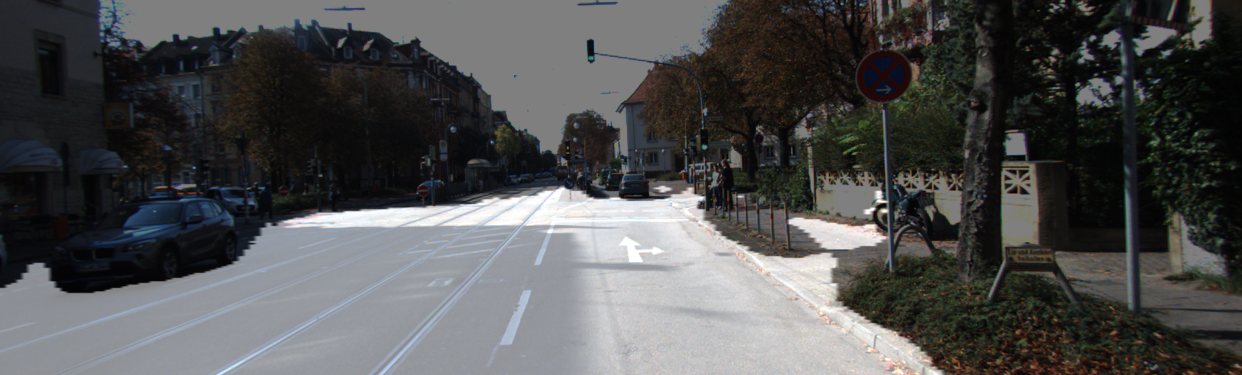

In [9]:
def get_output(model, preproc, image_path, output_path):
    #  image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

도로 부분이 하얗게 **오버레이(overlay)** 된것을 확인할 수 있습니다.

### IoU(Intersection over Union) - 세그멘테이션 성능 측정

**`Intersection / Union`**

세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다.  

IoU를 계산하기 위해선 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 각각을 **prediction**, **target**이라고 불렀을 때 이를 계산하는 함수를 구현해 보겠습니다.   


위에 구현했던 **get_output**을 좀더 확장해서 output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [10]:
def calculate_iou_score(target, prediction, index=None):
    intersection = np.logical_and(target, prediction)  # 실제 도로와 도로를 예측한 부분의 intersection
    union = np.logical_or(target, prediction)          # 실제 도로와 도로를 예측한 부분의 union
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    if not index :
        print('IoU : %f' % iou_score )
    else :
        print(f'index_{index} IoU : %f' % iou_score )
    return iou_score

In [11]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)  # 배열이 주어지면 Image 객체로 변환할 수 있습니다.
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [12]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.893522


0.8935215345638798

지금까지 U-Net를 구현하고 IoU를 구해서 성능을 측정하는 단계를 거쳤습니다.   
이제 **U-Net**에서 향상된 모델인 **U-net++**를 사용해 모델을 구현하고 비교해보겠습니다.

## 2. U-Net++ 모델의 구현
U-Net 모델의 개선된 구조인 U-Net++ 모델을 구현하겠습니다.   

**U-Net++** 모델은 DenseNet의 Dense block 아이디어를 사용하여 U-Net을 향상시켰습니다. 기존의 U-Net과 다른 점으로는 아래와 같습니다.   

1. skip pathways에 convolution 층이 있는 것이다. 이것은 encoder과 decoder 특징 맵 사이의 semantic gap을 연결해 줍니다.   


2. skip pathways에 dense skip이 있으며, 기울기의 흐름을 향상시키는 역할을 합니다.  


3. 모델 가지치기 향상이 가능하게 하거나 최악의 경우 하나의 loss 층만을 사용한 것과 유사한 성능을 달성하는 deep supervision이 있습니다.

In [7]:
import keras
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Input, merge, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2


![loss_function.png](./images/loss_function.png)

U-Net++는 손실 함수로써 binary cross-entropy와 dice coefficient를 결합한 것을 사용합니다.  
binary cross-entropy로 구한 loss값의 0.5를 곱한 값에  **`dice_coef() [custom loss function]`**를 빼줍니다.   


In [8]:
smooth = 1.
dropout_rate = 0.3

In [9]:
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [10]:
def Nest_Net_block(input_shape, stage, filters, kernel_size=3):
    # [conv2D + Dropout]로 이루어진 block 2개 
    activation = 'relu'

    x = Conv2D(filters, (kernel_size, kernel_size), name='Conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_shape)
    #x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = BatchNormalization(name='Batch' + stage+'_1')(x)
    x = Activation(activation=activation,  name='Activation'+ stage+'_1')(x)
    
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    
    x = Conv2D(filters, (kernel_size, kernel_size),  name='Conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization(name='Batch' + stage+'_2')(x)
    x = Activation(activation=activation, name='Activation'+ stage+'_2')(x)
    

    return x


### network 구조 설계 
Up-sampling과 Down-sampling를 Skip-connection과 섞어서 진행한다.     

model의 전체 구조는 다음과 같다.  

> **1 stage : layer 5개   &nbsp;&nbsp;  ->  &nbsp;&nbsp; 2 stage : layer 4개  &nbsp;&nbsp;  -> &nbsp;&nbsp; 3 stage : layer 3개 &nbsp;&nbsp; -> &nbsp;&nbsp; <br> 4 stage : layer 2개 &nbsp;&nbsp; -> &nbsp;&nbsp;  5 stage : layer 1개**


위에서 부터 점점 감소하면서 Down sampling를 하면서 그 아래의 layer와 skip-connection으로 UpSampling을 하는 구조이다.    

#### Deep Supervision
출력 부분에선 [conv1_2, conv1_3, conv1_4, conv1_5] 4개의 OutPut을 가질 수 있다.   
여기서 4개의 output의 평균을 가지는 것이 deep_supervision이고 이것을 사용하지 않는다면 출력은 [**conv1_5**]만 사용한다.


### Up-Sampling
Up-Sampling를 하는 방법에는 크게 2가지가 있다.    

1. Conv2DTranspose를 사용해서 Convolution을 하면서 고해상도를 올리는 방법

2. UpSampling2D를 사용해서 keras 내부적으로 resize_images()를 호출해 image의 사이즈를 늘린 후 Convolution 연산을 하는 방법

위의 2가지 방법을 모두 사용해서 어느 것이 더 좋은 결과가 나오는지도 비교해 보겠습니다.  

---

#### Conv2DTranspose()를 사용한 image_size UP_Sampling
- Up-Sampling과는 다르게 Convolution 하면서 image_size를 늘리기 때문에 추가적인 Convolution 레이어는 사용하지 않습니다.  

In [14]:
def Nest_Net(input_shape=(224, 224, 3), num_class=1, deep_supervision=False):
    # 기본 Conv는 위에 있는 Nest Net block를 사용한다. 
    # up이 아닌 경우 conv한 후 MaxPooling을 한다. 
    filters = [64,128,256,512,1024]

    # Handle Dimension Ordering for different backends
    
    bn_axis=3

    img_input = Input(shape=input_shape, name='main_input')
    
    conv1_1 = Nest_Net_block(img_input, stage='11', filters=filters[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = Nest_Net_block(pool1, stage='21', filters=filters[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = Nest_Net_block(conv1_2, stage='12', filters=filters[0])

    conv3_1 = Nest_Net_block(pool2, stage='31', filters=filters[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = Nest_Net_block(conv2_2, stage='22', filters=filters[1])

    up1_3 = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = Nest_Net_block(conv1_3, stage='13', filters=filters[0])

    conv4_1 = Nest_Net_block(pool3, stage='41', filters=filters[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = Nest_Net_block(conv3_2, stage='32', filters=filters[2])

    up2_3 = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = Nest_Net_block(conv2_3, stage='23', filters=filters[1])

    up1_4 = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = Nest_Net_block(conv1_4, stage='14', filters=filters[0])

    conv5_1 = Nest_Net_block(pool4, stage='51', filters=filters[4])

    up4_2 = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = Nest_Net_block(conv4_2, stage='42', filters=filters[3])

    up3_3 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = Nest_Net_block(conv3_3, stage='33', filters=filters[2])

    up2_4 = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = Nest_Net_block(conv2_4, stage='24', filters=filters[1])

    up1_5 = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = Nest_Net_block(conv1_5, stage='15', filters=filters[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=img_input, outputs=[nestnet_output_4])

    return model

In [15]:
input_shape = (224,224,3)
model = Nest_Net(input_shape, deep_supervision=False)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv11_1 (Conv2D)               (None, 224, 224, 64) 1792        main_input[0][0]                 
__________________________________________________________________________________________________
Batch11_1 (BatchNormalization)  (None, 224, 224, 64) 256         Conv11_1[0][0]                   
__________________________________________________________________________________________________
Activation11_1 (Activation)     (None, 224, 224, 64) 0           Batch11_1[0][0]                  
_______________________________________________________________________________________

#### Upsampling2D() 메서드를 사용한 image_size UP_Sampling

UpSampling2D를 사용해서 image_size를 늘렸지만, Convolution은 들어가지 않았기에 Convolution layer를 추가로 넣습니다.  

In [11]:
def upSampling_block(input_size ,filters,  stage, kernel_size=(2,2)):
    up_sample = UpSampling2D(name='up'+stage)(input_size)
    conv_up = Conv2D(filters, (kernel_size, kernel_size) , padding='same', name='conv'+stage+'_up')(up_sample)
    return conv_up

In [14]:
def Nest_Net(input_shape=(224, 224, 3), num_class=1, deep_supervision=False):
    # 기본 Conv는 위에 있는 Nest Net block를 사용한다. 
    # up이 아닌 경우 conv한 후 MaxPooling을 한다. 
    #filters = [32,64,128,256,512]
    filters = [64,128,256,512,1024]
    
    
    bn_axis=3

    img_input = Input(shape=input_shape, name='main_input')
    
    conv1_1 = Nest_Net_block(img_input, stage='1_1', filters=filters[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    
    conv2_1 = Nest_Net_block(pool1, stage='2_1', filters=filters[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)


    up1_2 = upSampling_block(conv2_1,filters=filters[0], kernel_size=2, stage='1_2')
    conv1_2 = concatenate([up1_2, conv1_1], name='merge1_2', axis=bn_axis)
    conv1_2 = Nest_Net_block(conv1_2, stage='1_2', filters=filters[0])

    conv3_1 = Nest_Net_block(pool2, stage='3_1', filters=filters[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    
    up2_2 = upSampling_block(conv3_1,filters=filters[1], kernel_size=2, stage='2_2')
    conv2_2 = concatenate([up2_2, conv2_1], name='merge2_2', axis=bn_axis)
    conv2_2 = Nest_Net_block(conv2_2, stage='2_2', filters=filters[1])

    
    up1_3 = upSampling_block(conv2_2,filters=filters[0], kernel_size=2, stage='1_3')    
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge1_3', axis=bn_axis)
    conv1_3 = Nest_Net_block(conv1_3, stage='1_3', filters=filters[0])

    
    conv4_1 = Nest_Net_block(pool3, stage='4_1', filters=filters[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    
    up3_2 = upSampling_block(conv4_1,filters=filters[2], kernel_size=2, stage='3_2')    
    conv3_2 = concatenate([up3_2, conv3_1], name='merge3_2', axis=bn_axis)
    conv3_2 = Nest_Net_block(conv3_2, stage='3_2', filters=filters[2])

    
    up2_3 = upSampling_block(conv3_2,filters=filters[1], kernel_size=2, stage='2_3')    
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge2_3', axis=bn_axis)
    conv2_3 = Nest_Net_block(conv2_3, stage='2_3', filters=filters[1])

    
    up1_4 = upSampling_block(conv2_3,filters=filters[0], kernel_size=2, stage='1_4')
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge1_4', axis=bn_axis)
    conv1_4 = Nest_Net_block(conv1_4, stage='1_4', filters=filters[0])

    
    conv5_1 = Nest_Net_block(pool4, stage='5_1', filters=filters[4])
    
    
    up4_2 = upSampling_block(conv5_1,filters=filters[3], kernel_size=2, stage='4_2')    
    conv4_2 = concatenate([up4_2, conv4_1], name='merge4_2', axis=bn_axis)
    conv4_2 = Nest_Net_block(conv4_2, stage='4_2', filters=filters[3])

    
    up3_3 = upSampling_block(conv4_2,filters=filters[2], kernel_size=2, stage='3_3')
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge3_3', axis=bn_axis)
    conv3_3 = Nest_Net_block(conv3_3, stage='3_3', filters=filters[2])

    
    up2_4 = upSampling_block(conv3_3,filters=filters[1], kernel_size=2, stage='2_4')    
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge2_4', axis=bn_axis)
    conv2_4 = Nest_Net_block(conv2_4, stage='2_4', filters=filters[1])

    
    up1_5 = upSampling_block(conv2_4,filters=filters[0], kernel_size=2, stage='1_5')    
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge1_5', axis=bn_axis)
    conv1_5 = Nest_Net_block(conv1_5, stage='1_5', filters=filters[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=img_input, outputs=[nestnet_output_4])

    return model

In [13]:
input_shape = (224,224,3)
model = Nest_Net(input_shape, deep_supervision=False)

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_1_1 (Conv2D)              (None, 224, 224, 64) 1792        main_input[0][0]                 
__________________________________________________________________________________________________
Batch1_1_1 (BatchNormalization) (None, 224, 224, 64) 256         Conv1_1_1[0][0]                  
__________________________________________________________________________________________________
Activation1_1_1 (Activation)    (None, 224, 224, 64) 0           Batch1_1_1[0][0]                 
_______________________________________________________________________________________

### U-Net++ 모델 학습하기
---
모델을 학습한 후 메모리를 많이 차지하므로 저장해서 불러오도록 합니다.   
U-Net++의 deep supervision은 사용한 학습을 진행하겠습니다.

In [15]:
# v10
# binary cross entropy와 custom loss function인 dice_coef를 사용한 loss function을 사용합니다.
model.compile(optimizer = Adam(lr = 1e-4), loss = bce_dice_loss)
#model.compile(optimizer = Adam(lr = 1e-4), loss = bce_dice_loss)
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=200,
)


model_path = dir_path + '/seg_model_unet++10.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/200
43/43 [==============================] - 16s 379ms/step - loss: 1.5751 - val_loss: 1.3657
Epoch 2/200
43/43 [==============================] - 16s 371ms/step - loss: 1.1510 - val_loss: 1.3876
Epoch 3/200
43/43 [==============================] - 16s 373ms/step - loss: 0.9807 - val_loss: 1.7800
Epoch 4/200
43/43 [==============================] - 16s 375ms/step - loss: 0.8043 - val_loss: 1.8667
Epoch 5/200
43/43 [==============================] - 16s 375ms/step - loss: 0.6710 - val_loss: 1.8575
Epoch 6/200
43/43 [==============================] - 16s 376ms/step - loss: 0.5904 - val_loss: 2.5295
Epoch 7/200
43/43 [==============================] - 16s 376ms/step - loss: 0.5875 - val_loss: 0.8729
Epoch 8/200
43/43 [==============================] - 16s 376ms/step - loss: 0.5576 - val_loss: 0.4970
Epoch 9/200
43/43 [==============================] - 16s 377ms/step - loss: 0.4992 - val_loss: 0.4741
Epoch 10/200
43/43 [==============================] - 16s 378ms/step - loss: 0.386

43/43 [==============================] - 16s 377ms/step - loss: -0.4228 - val_loss: -0.4060
Epoch 80/200
43/43 [==============================] - 16s 377ms/step - loss: -0.4927 - val_loss: -0.2292
Epoch 81/200
43/43 [==============================] - 16s 377ms/step - loss: -0.4524 - val_loss: -0.4712
Epoch 82/200
43/43 [==============================] - 16s 377ms/step - loss: -0.5110 - val_loss: -0.5191
Epoch 83/200
43/43 [==============================] - 16s 377ms/step - loss: -0.4456 - val_loss: -0.5340
Epoch 84/200
43/43 [==============================] - 16s 377ms/step - loss: -0.4822 - val_loss: -0.4635
Epoch 85/200
43/43 [==============================] - 16s 377ms/step - loss: -0.5467 - val_loss: -0.4760
Epoch 86/200
43/43 [==============================] - 16s 377ms/step - loss: -0.5310 - val_loss: -0.5463
Epoch 87/200
43/43 [==============================] - 16s 377ms/step - loss: -0.5195 - val_loss: -0.2270
Epoch 88/200
43/43 [==============================] - 16s 377ms/step

43/43 [==============================] - 16s 377ms/step - loss: -0.6063 - val_loss: -0.6087
Epoch 157/200
43/43 [==============================] - 16s 377ms/step - loss: -0.6269 - val_loss: -0.6002
Epoch 158/200
43/43 [==============================] - 16s 377ms/step - loss: -0.5216 - val_loss: -0.2228
Epoch 159/200
43/43 [==============================] - 16s 378ms/step - loss: -0.6119 - val_loss: -0.4945
Epoch 160/200
43/43 [==============================] - 16s 377ms/step - loss: -0.5866 - val_loss: -0.4884
Epoch 161/200
43/43 [==============================] - 16s 377ms/step - loss: -0.6415 - val_loss: -0.4381
Epoch 162/200
43/43 [==============================] - 16s 377ms/step - loss: -0.5280 - val_loss: -0.5762
Epoch 163/200
43/43 [==============================] - 16s 376ms/step - loss: -0.5875 - val_loss: -0.4475
Epoch 164/200
43/43 [==============================] - 16s 377ms/step - loss: -0.6431 - val_loss: -0.6115
Epoch 165/200
43/43 [==============================] - 16s 3

---

모델은 다음과 같이 load해서 사용할 수 있습니다.

In [15]:
dir_path

'/home/ssac27/aiffel/semantic_segmentation/data/training'

In [35]:
model_path = dir_path + '/seg_model_unet++12_upsample.h5'

In [37]:
model = tf.keras.models.load_model(model_path,compile=False)  # bce_dice_loss 사용시
#model = tf.keras.models.load_model(model_path)  

## 3. U-Net 과 U-Net++ 모델들이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다.    
추가로, U-Net++의 경우 사용할 수 있는 2가지의 **loss function**과  **UpSampling**을 할 수 있는 2가지 방법(UpSampling2D, Conv2DTranspose)에 대해서도 비교해 봅시다.     

In [14]:
def calculate_iou_score(target, prediction, index=None):
    intersection = np.logical_and(target, prediction)  # 실제 도로와 도로를 예측한 부분의 intersection
    union = np.logical_or(target, prediction)          # 실제 도로와 도로를 예측한 부분의 union
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    if not index :
        print('IoU : %f' % iou_score )
    else :
        print(f'index_{index} IoU : %f' % iou_score )
    return iou_score

In [41]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)  # 배열이 주어지면 Image 객체로 변환할 수 있습니다.
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### bce_dice_loss vs binary_crossentropy  [U-Net++  loss function]
U-net++에서 **`binary_crossentropy`**와 custom loss function인 와  **`dice_coef`**를 결합하여 만든 **`bce_dice_loss`**를 사용한 결과와 **`binary_crossentropy`**만 사용한 결과를 비교해 보겠습니다.   

<br><br>

<details markdown="1">
    <summary> ▶ <b>bce_dice_loss() 함수와 dice_coef() 함수 상세 보기</b></summary>
    
``` python
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
```

</details>

### bce_dice_loss 세그멘테이션 및 결과
model_v8

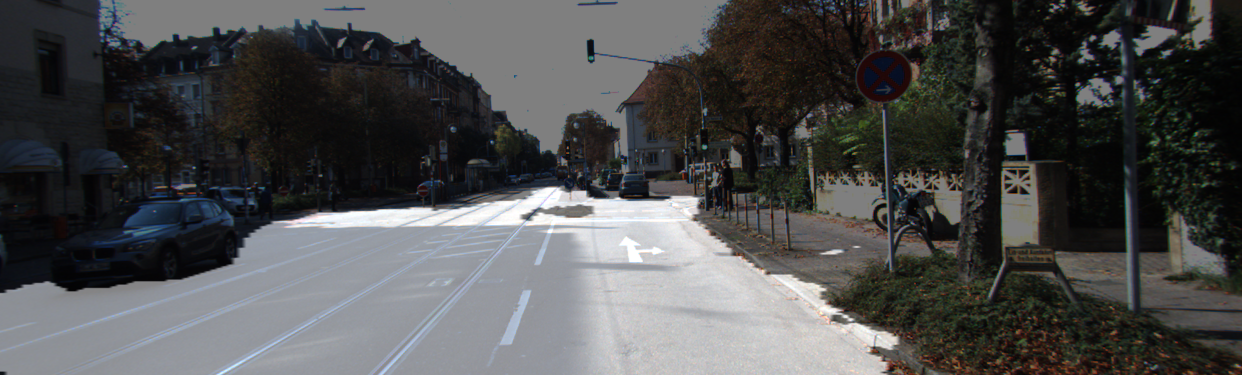

In [22]:
# model u-net++_v10  bce_dice_loss 사용
def get_output(model, preproc, image_path, output_path):
    #  image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [16]:
n = 2  # i값을 바꾸면 테스트용 파일이 달라집니다. 

for i in range(1,n):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    calculate_iou_score(target, prediction,index=i)
    

index_1 IoU : 0.931261


---

### binary_crossentropy 세그멘테이션 및 결과 
model_v10

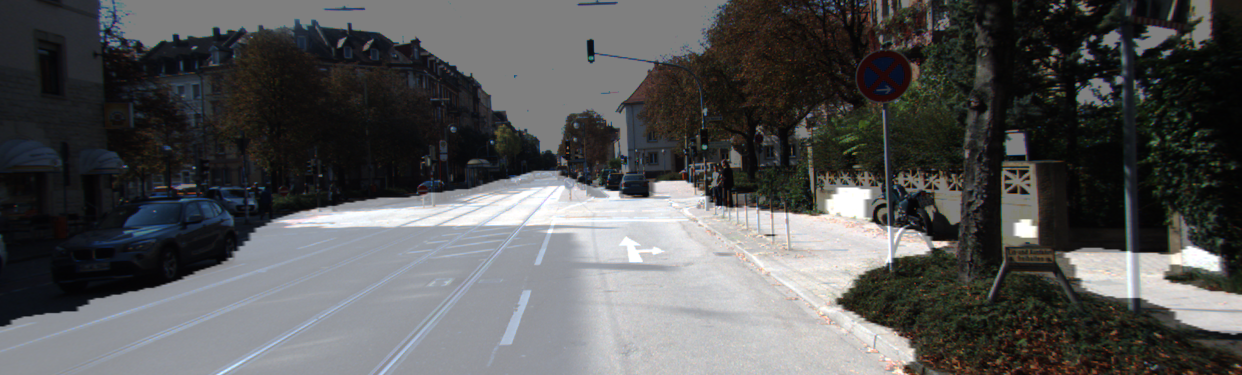

In [17]:
# model u-net++_v8  binary_crossentropy 사용
def get_output(model, preproc, image_path, output_path):
    #  image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [21]:
n = 2  # i값을 바꾸면 테스트용 파일이 달라집니다. 

for i in range(1,2):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    calculate_iou_score(target, prediction,index=i)
    

index_1 IoU : 0.764263


### bce_dice_loss vs binary_crossentropy
결과는 위에 보이는것과 같이 **`bce_dice_loss`**가 더 좋은 결과를 보이고 있습니다.   

---

### UpSampling2D vs Conv2DTranspose  [U-Net++  Up-sampling 방법] 

U-net++에서 **`UpSampling2D`**과  **`Conv2DTranspose`**의 결과를 비교해 보겠습니다.   

- 위에서 사용한 [model_8, model_10] 모델들의 경우 Conv2DTranspose를 사용하였으니 **`UpSampling2D`**를 사용한 2 모델을 불러와서 비교해 보겠습니다.   

### UpSampling2D + binary_crossentropy 세그멘테이션 및 결과 
model_v11

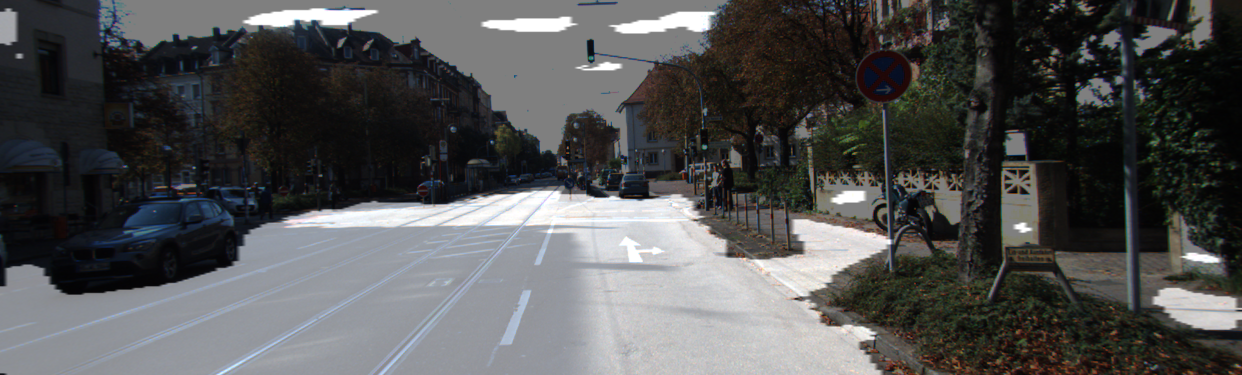

In [22]:
# model u-net++_v11  binary_crossentropy 사용
def get_output(model, preproc, image_path, output_path):
    #  image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [25]:
n = 2  # i값을 바꾸면 테스트용 파일이 달라집니다. 

for i in range(1,2):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    calculate_iou_score(target, prediction,index=i)
    

index_1 IoU : 0.860976


### UpSampling2D + bce_dice_loss 세그멘테이션 및 결과 
model_v12

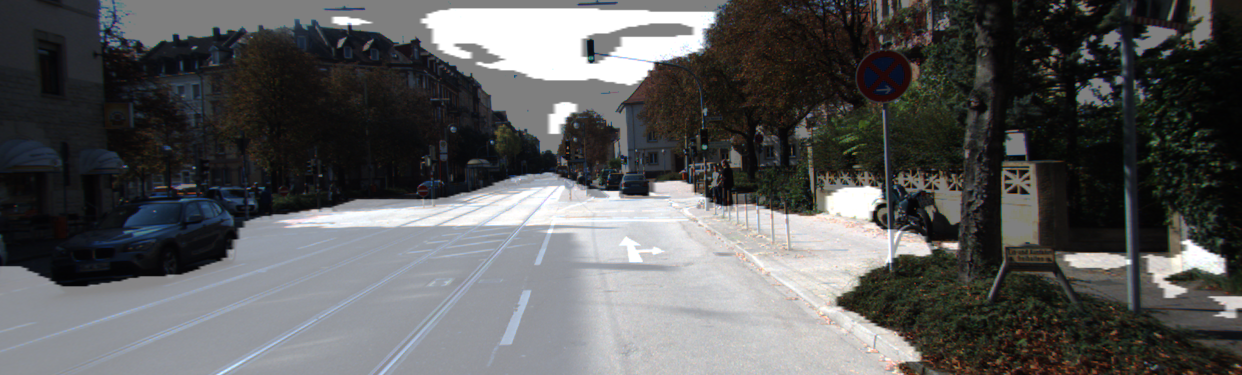

In [39]:
# model u-net++_v12  bce_dice_loss 사용
def get_output(model, preproc, image_path, output_path):
    #  image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [42]:
n = 2  # i값을 바꾸면 테스트용 파일이 달라집니다. 

for i in range(1,2):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    calculate_iou_score(target, prediction,index=i)
    

index_1 IoU : 0.738070


위에 결과들을 표로 나타내면 다음과 같습니다.  

![U-NetPlus_models.jpg](./images/U-NetPlus_models.jpg)

---

### U-Net 세그멘테이션 및 결과 

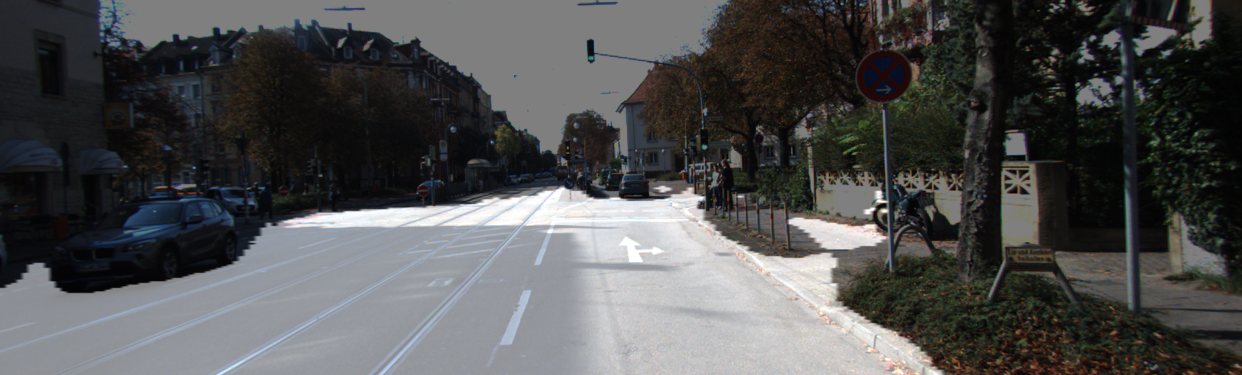

In [9]:
def get_output(model, preproc, image_path, output_path):
    #  image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [12]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.893522


0.8935215345638798

U-Net의 결과와 U-Net++에 가장 좋았던 결과를 비교해보면 다음과 같습니다.  

> **image_1 기준**  
>- **U-Net : 0.893522**    
>- **U-Net++ : 0.931261**    

IoU값 비교 결과 **`U-Net++`**가 **`U-Net`**보다 더 좋은 성능을 나타내고 있네요.

[결과 표 :]   


![U-NetPlus_U-Net.jpg](./images/U-NetPlus_U-Net.jpg)

## 회고  

- ResNet을 설계 했던 경험이 이번 U-Net++을 설계하면서 많은 도움이 된것 같습니다.  
ResNet 모델을 직접 설계하고 U-Net 구조도 직접 설계하면서 얻은 모델의 구조에 대한 정보들이 U-Net++의 구조를 짜는데 도움이 되었습니다.   


- U-Net++를 짜면서 U-Ne이랑 비교했을떄 엄청난 차이가 있을 줄 알았지만, 막상 비교해 보니 그렇게 큰차이는 발생하지 않았네요.   [0.04] 4%가 작은 차이는 아니지만, 0.1 정도까지 차이가 날 줄 알았으니 이렇게 보면 생각보다는 적게 차이가 난것 같습니다.   


- 이번에 U-Net++를 짜면서 Up-Sampling를 하는 방법에 대해 알게되었고 학습에 사용되는 loss function의 차이가 어떤 결과를 일으키는지 확인할 수 있었습니다.   
Up-Sampling의 경우 가장 좋았던 결과가 **Conv2DTranspose**이고  가장 안좋았던 결과는 **Up-Sampling**에서 나온것을 생각해 보면  **Conv2DTranspose**가 더 좋은 결과를 만들어낼 수 있을것 같지만,  **Conv2DTranspose**를 사용한 두 모델의 차이가 심해서 선뜻 어느 방법이 더 좋은지 말하기는 애매한것 같습니다.   
그래도 어떨때 사용하는것이 나은지 설명하자면, **Conv2DTranspose**의 방법은 image_resize와 Convolution을 같이 진행하기에 **Conv2DTranspose**를 사용하는게 코드의 길이를 더 짧게 줄여줄 수 있어서 코드 길이를 간단히 줄이는것이 목적이라면, **Up-Sampling**보다 **Conv2DTranspose**를 사용하는것이 더 나은것 같습니다.  